## Analyzing A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

The aim of this report is to understand the results of an A/B test run by an e-commerce website, to help a company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#The seed is set below just to ensure the results are similar each time the notebook runs
random.seed(42)

Let's take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The number of rows in the dataset is:

In [3]:
df.shape[0]

294478

The number of unique users in the dataset:

In [4]:
df.user_id.nunique()

290584

The proportion of users converted:

In [5]:
df.converted.mean()

0.11965919355605512

The number of times the `new_page` and `treatment` don't match:

In [6]:
df.query('(landing_page == "new_page" and group == "control") or (landing_page == "old_page" and group == "treatment")').count()[0]

3893

Let's check if there are missing values.

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.

To handle this, I'll create a new dataset **df2**.

In [8]:
# Creating new data frame.
df2 = df[((df['group'] == 'treatment') & (df['landing_page'] == 'new_page')) | ((df['group'] == 'control') & (df['landing_page'] == 'old_page'))]

In [9]:
# Double checking that all of the correct rows were removed. 0 means they were.
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

Number of unique **user_id**s are in **df2**:

In [10]:
df2.user_id.nunique()

290584

There is one **user_id** repeated in **df2**.

In [11]:
# Looking for the duplicated user_id
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

Let's take a closer look:

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


I'll remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(subset='user_id')

The probability of an individual converting regardless of the page they receive:

In [14]:
df2.converted.mean()

0.11959708724499628

Given that an individual was in the `control` group, the probability they converted is:

In [15]:
df2.query('group == "control"').converted.mean()

0.1203863045004612

Given that an individual was in the `treatment` group, the probability they converted is:

In [16]:
df2.query('group == "treatment"').converted.mean()

0.11880806551510564

The probability that an individual received the new page:

In [17]:
df2.query('landing_page == "new_page"').count()[0] / df2.shape[0]

0.50006194422266881

**Preliminary Conclusion**: According to the data, there is a slight higher probability that on average an individual will convert for the control group than for the treatment group. But this is not enough evidence to conclude that the control group page leads to more conversions than the treatment group page. First we must assess if these results are statistically significant.
<br/> At the moment, it also seems like such a small different will not be practically signigicant, even if we manage to show that it is statistically significant.

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, I could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do I stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do I run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, I'll consider I need to make the decision just based on all the data provided.  I'll assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. Thus, the null and alternative hypotheses are:


$$H_0: p_{old}\geq p_{new}$$


$$H_1: p_{old}< p_{new}$$

I'll assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, I'll assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I'll use a sample size for each page equal to the ones in **ab_data.csv**, and perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

The **conversion rate** for $p_{new}$ under the null:

In [18]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

The **conversion rate** for $p_{old}$ under the null:

In [19]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

$n_{new}$, the number of individuals in the treatment group is:

In [20]:
n_new = df2.query('group == "treatment"').count()[0]
n_new

145310

$n_{old}$, the number of individuals in the control group is:

In [21]:
n_old = df2.query('group == "control"').count()[0]
n_old

145274

Now, I'll simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null, and store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
# Simulating using 1's and 0's for the size of n_new and with probabilities p_new and 1-p_new
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, 1-p_new])

Now, I'll simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null, and store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
# Simulating using 1's and 0's for the size of n_old and with probabilities p_old and 1-p_old
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, 1-p_old])

$p_{new}$ - $p_{old}$ for the simulated values:

In [24]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.0010619868133879828

I'll create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process used earlier, and store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
# Initializing p_diffs
p_diffs = []

# Simulating 10000 times the calculation of the mean and appending the difference of means to p_diffs
for _ in range(10000):
    new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, 1-p_new])
    old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, 1-p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

Histogram of the **p_diffs**.

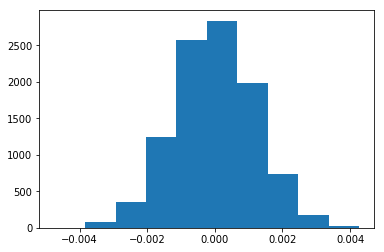

In [26]:
plt.hist(p_diffs);

It looks like what I expected: a normal distribution of the means.

The proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**:

In [27]:
# Calculate the observed difference
obs_diff = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()

# Convert p_diffs to np.array
p_diffs = np.array(p_diffs)

# Calculated the p_values using values larger than the observed mean
p_value = (p_diffs > obs_diff).mean()
p_value

0.90790000000000004

**Preliminary Conclusion**:
I have computed the p-value, which is the probability of getting our statistic or a more extreme value if the null is true.

In this case, a p-value that is close to 1 means that we have failed to reject the null hypothesis. That is, we have failed to reject our assumption that there is no difference between new and old pages, or that old pages are "better" than new_pages.

We can also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Below I calculate the number of conversions for each page, as well as the number of individuals who received each page. `n_old` and `n_new` refer to the number of rows associated with the old page and new pages, respectively.

In [28]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"').converted.sum()
convert_new = df2.query('landing_page == "new_page"').converted.sum()
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now I use `stats.proportions_ztest` to compute the test statistic and p-value. 

In [29]:
zstat, pval = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
zstat, pval

(1.3109241984234394, 0.90505831275902449)

**Preliminary Conclusion**: 
A z-score below 1.5 means that the conversion rate for the new page is less than he 95% of the old page, hence re-enforcing that we cannot reject the null hypotesis. I can also see that the p-value is very similar to the one I calculated earlier, so this would mean again that we fail to reject the null hypothesis. So z-score and p-value agree with the previous findings.

<a id='regression'></a>
### Part III - A regression approach

In this final part, I will show how the result I achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, the best type of regression would be logistic regression.

The goal is to use **statsmodels** to fit the regression model to see if there is a significant difference in conversion based on which page a customer receives. However, I first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received. I'll add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1

# Creating dummies
df2[['ab_page0', 'ab_page']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop('ab_page0', axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1


Now, I'll use **statsmodels** to instantiate the regression model on the two columns you created in part b., then fit the model using the two columns created earlier, to predict whether or not an individual converts. 

In [31]:
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


Summary of the model:

In [32]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-21 13:27 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0038    0.0081  -247.1457  0.0000  -2.0197  -1.9879
ab_page       0.0150    0.0114     1.3109  0.1899  -0.0074   0.0374
==================================================================

"""

**Preliminary Conclusion**: The p-value is 0.1899. The p-values differ because the null and alternative hypotheses differ. Here we are testing for
$$H_0: p_{old}= p_{new}$$


$$H_1: p_{old}\neq p_{new}$$

and earlier for
$$H_0: p_{old}\geq p_{new}$$


$$H_1: p_{old}< p_{new}$$

Our logistic regression model is saying that we can reject the null hypothesis $$H_0: p_{old}= p_{new}$$

**Important Note**: Adding more relevant factors can prevent bias in the estimate of the other regression coefficients, but can also increase variance of other regression coefficients.

g. Now along with testing if the conversion rate changes for different pages, I'll add an effect based on which country a user lives in. I will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.

I'll create two columns fot the three dummy variables for these country columns:

In [33]:
df_country = pd.read_csv('countries.csv')
df3 = df_country.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0


In [34]:
df3.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [35]:
df3[['US', 'UK']] = pd.get_dummies(df3['country'])[['US','UK']]
df3.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,0,1


In [36]:
lm = sm.Logit(df3['converted'], df3[['intercept', 'US', 'UK']])
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-21 13:27 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
==================================================================

"""

**Interpretation of results**: The p-values are greater than 0.05, therefore, the difference in countries does not seem to have a significant impact on conversion.

Now I'll look at an interaction between page and country to see if there significant effects on conversion, by creating the necessary additional columns, and fit the new model.  

In [37]:
# Create additional columns to look at the interaction between page and country
df3['US_ab_page'] = df3['US'] * df3['ab_page']
df3['UK_ab_page'] = df3['UK'] * df3['ab_page']

In [38]:
# Create a model to see if there are significant effects on conversion in the interaction between page and country
lm = sm.Logit(df3['converted'], df3[['intercept','ab_page', 'US', 'UK','US_ab_page','UK_ab_page']])
results = lm.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-06-21 13:27 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0715    0.0371  -55.7977  0.0000  -2.1442  -1.9987
ab_page        0.0674    0.0520    1.2967  0.1947  -0.0345   0.1694
US             0.0644    0.0384    1.6788  0.0932  -0.0108   0.1396
UK             0.0901    0.0405    2.2252  0.0261   0.0107   0.1694
US_ab_page    -0.0469    0.0538   -0.8718  0.3833  -0.1523   0.0585
UK_ab_page    -0.0783    0.0568   -1.3783  0.1681  -0.1896   0.0330
==================================================================

"""

In [39]:
# Exponentiating coefficients
exp_coef = np.exp(results.params)

In [40]:
# Inverting exponentiated coefficents
1/exp_coef

intercept     7.936353
ab_page       0.934776
US            0.937618
UK            0.913871
US_ab_page    1.048001
UK_ab_page    1.081428
dtype: float64

**Interpretation of results**: Again p-values are greater than 0.05, therefore, the difference in countries and interaction between page and country does not seem to have a significant impact on conversion.

For the new page, an individual is -0.06 times more likely to be convert, holding all other variables constant

If an individual is from Canada, they are 0.92 times more likely to convert for the new page, than if they were from the UK, holding all other variables constant.

If an individual is from Canada, they are 0.95 times more likely to convert for the new page, than if they were from the US, holding all other variables constant.

Furthemore, these differences are so small, that the results should not be considered practically signigicant.